 Example                                                                 

 Program SWMS_2D
 Time independent boundary conditions
 Axisymmetric flow, V = L*L*L
 Units: L = cm   , T = min  , M = -    
 -----------------------------------------------------
 |                                                   |
 |                     SWMS_2D                       |
 |                                                   |
 |     Code for simulating water flow and solute     |
 |       transport in two-dimensional variably       |
 |             saturated porous media                |
 |                                                   |
 |                  version 1.22                     |
 |          Last modified: January, 1994             |
 |                                                   |
 -----------------------------------------------------

 Example                                                                 
 Axisymmetric flow, V = L*L*L
 reading nodal information
 reading

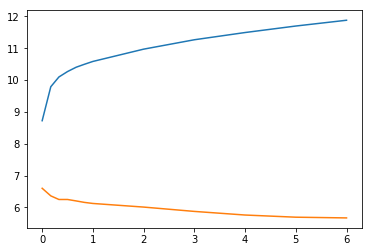

In [64]:
"""Programme forward pour modéliser les temps d'arrivée de la réflexion sur le bulbe lors d'une injection de type Porchet
suivie par radar de sol"""

%matplotlib inline

import numpy as np
import os
#import matplotlib.pyplot as plt
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh

from definition_maillage import *
from ecriture_fich_gprMax import *
from ecriture_in import *
from interp_charge_trou import *
from interp_maillage_gprMax import *

#Def des paramètres de géométrie du modéle
xmin,xmax = 0, 40 # en cm
emin,emax = 0, 80 #  elevation en cm
dtrou = 30 # prof du trou en cm
etrou = emax - dtrou # elevation du fond du trou
r=2 # rayon du trou en cm
dx = .1 #On définit le pas de la maille
zaff= 20 #profondeur en cm jusqu'où on souhaite un maillage affiné. 
eaff=etrou-zaff

h_0=-78 #-80 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #10 #hauteur d'eau au fond du trou en cm

#Définition du maillage triangulaire
[mesh, pg_pos, mesh_pos, mesh_cells]=definition_maillage(xmin, xmax, emin, emax, dtrou, etrou, r, dx, zaff, eaff)

#Début de la boucle de calcul
for i in range(0,1):
    tr = 0.049 #0.06
    ts = 0.39 #0.3
    alpha = 0.0348 #0.016
    n = 1.7458 #8.52
    Ks = 0.0731 #0.07
    param = [tr, ts, tr, ts, alpha, n, Ks, Ks, ts] #Paramètres d'entrée tr, ts, alpha, n, Ks
    #temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 1.17, 1.33, 1.50, 1.67, 1.83, 2.00, 2.17, 2.33, 2.50, 2.67, 2.83, 3.00, 3.17, 3.33, 3.50, 3.67, 3.83, 4.00, 4.17, 4.33, 4.50, 4.67, 4.83, 5.00, 5.17, 5.33, 5.50, 5.67, 5.83, 6.00]#Temps de calcul en minutes
    #temps=[1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
    temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
    
    #Interpolation de la charge sur les bords du trou
    [p, charge_imp, n_free_drainage, n_total]=interp_charge_trou(mesh_pos, etrou, r, h_0, h_1)

    #Création des fichiers .in nécessaires pour SMWS_2D
    ecriture_in(mesh, param, temps, p, n_total)

    #Lancement SWMS_2D
    !cp Grid.in SWMS_2D.IN/
    !cp Selector.in SWMS_2D.IN/
    !~/Codes/HD2/H2D

    #Interpolation du maillage sur une grille rectangulaire 2D pour gprMax
    #On crée un maillage rectangulaire avec les dimensions du modèle
    xmin, xmax = 0.0, 40.
    zmin, zmax = 0.0, 80.

    dx = 1.0 #en cm

    #fich_thetas = "TEST_AFF/th.out" #Fichier contenant les thetas
    fich_thetas = "SWMS_2D.OUT/th.out" #Fichier contenant les thetas

    [xv, yv, T, mx, my, mesh2, grid, grid_mat, eps_mat, sigma_grid_mat] = interp_maillage_gprMax(xmin, xmax, zmin, zmax, dx, param, mesh, mesh_pos[:,:2], fich_thetas, temps)

    import math
    #Lancement gprMax
    nom='Forward'
   
    sigma=0.0000
    #eps_w=80.1 #Epsilon eau
    eps_w=80.1
    eps_pvc=3 #Epsilon pvc
    eps_s=2.5 #Epsilon sable
    p=param[1] #Porosité = theta s
    #Maxieps=( math.sqrt(eps_w)*0.9*p + (1-p)*math.sqrt(eps_s) +0.1*p )**2
    Maxieps=( math.sqrt(eps_w)*p + (1-p)*math.sqrt(eps_s) )**2
    Minv=0.3/math.sqrt(Maxieps)
    #Minv=0.3/eps_w
    Minlambda=Minv*(10**9)/(2800*(10**6))
    dl=Minlambda/5

    time=0.000000030
    dx=abs((xv.T*0.01)[0,1]-(xv.T*0.01)[0,0])
    dy=abs((yv.T*0.01)[1,0]-(yv.T*0.01)[0,0])
    #dl=dx/2
    #dl=dx
    fac_dt = 0.2

    #Définition de ce qu'on a besoin pour gprMax
    import os
    import math
    from scipy.interpolate import griddata

    #for i in range(0,len(T)) :
    #    grid_z0 = griddata((mx, my), grid[:,i], (xv, yv), method='linear', fill_value=0.0).T
    
    materiaux = {}
    A_tab={}

    def materiau(x, sigma):
        if x in materiaux:
            return materiaux[x]
        valeur = "sand{}".format(len(materiaux))
        valeur2 = sigma
        materiaux[x] = valeur, valeur2
        return valeur, valeur2
    for i in range(0,len(T)+1):
        for j in range(0,81):
            for k in range(0,41):
                #grid_mat[i][j,k]=round(grid_mat[i][j,k],3)
                #grid_mat[i][j,k]=grid_mat[i][j,k]*2
                #f[i][j,k]=CRIM(grid_mat[i][j,k], eps_w,eps_s,p)
                materiau(grid_mat[i][j,k], sigma_grid_mat[i][j,k])
        #nmedia=len((yv.T*0.01)[:,0])*len(grid_mat[i][0,:])
        nmedia=len(materiaux)+2
        A,o=ecriture_fich_gprMax(param, xv.T*0.01, yv.T*0.01, T, grid_mat[i], i, param[6], nom, h_1*0.01, etrou*0.01, r*0.01, sigma, eps_w, eps_pvc, eps_s, p, nmedia, time, dx, dy, dl, fac_dt, materiaux)
        A_tab[i]=A
        fichier=nom+str(int(param[6]*1000))+'_'+str(i+1)+'.in'
        command="../gprMax "+fichier
        #print(command)
        os.popen(command).readlines()
    
    merge=nom+str(int(param[6]*1000))+'_'
    copy=nom+str(int(param[6]*1000))+'__merged.out'
    command2="../gprMaxMerge "+merge
    command3="cp "+copy+" RESULTS/."
    os.popen(command2).readlines()
    os.popen(command3).readlines()
    
    os.popen("rm -rf *.in")
    os.popen("rm -rf *.out")
    
    def picking(filename, A_tab) :
        import h5py
        f = h5py.File(filename, 'r')
        path = '/rxs/rx1/'
        #modelruns = f.attrs['Modelruns']
        modelruns=len(temps)+1
        samples = f.attrs['Iterations']
        dt = f.attrs['dt']*1e9
        #positions = f.attrs['Positions'][:,0,0]
        dx = 1
        #dx = np.diff(positions)[0]
        data = np.ones((samples, modelruns))
        t_max = np.zeros(modelruns)
        tt=np.zeros(modelruns)
        tps_bas = np.zeros(modelruns)
        tps_haut = np.zeros(modelruns)

        #Calcul du temps d'arrivé de la première réflexion:
        eps_init = A_tab[0][:,2].min()
        h = math.sqrt(0.3**2 + 0.2**2)
        v_init=0.3/(math.sqrt(eps_init))
        t_init = (2*h)/v_init
        #print(t_init)
        itmin = t_init/dt
        
        #Picking onde du bas (onde qui fait le tour du bulbe)
        
        for model in range(0,modelruns):
            data[:,model] = f['%s%s' % (path, 'Ez')][:,model]
            if model==0 :
                itmin_i = itmin
                itmax_i = itmin_i+180 #Correspond à environ 2 ns de fenètre
            else :
                itmin_i = tt[model-1]
                itmax_i = itmin_i+180
            t_max[model] = np.max(data[int(itmin_i):int(itmax_i),model])
            tt[model] = np.where(data[:,model]==t_max[model])[0]
            tps_bas[model] = tt[model]*dt   
        #print(t_max)
        #print(tt)
        #tps=tps-tps[0]
        #dx_dt=(dx,dt)
        #print(tps)
        #return tps
    
        #Picking onde du haut (onde directe)
        
        for model in range(0,modelruns):
            data[:,model] = f['%s%s' % (path, 'Ez')][:,model]
        #On commence par retirer la trace moyenne
        #for i in range(0,samples):
        #    moy_line = mean(data[i,:])
        #    data[i,:] = data[i,:]-moy_line
            if model == 0 :
                itmin_i = itmin+50
                itmax_i = itmin_i-400 #Il faut que itmax_i s'arrête avant l'onde directe (qui se finit vers 3 ns donc 3/dt=265 donc itmax_i>265)
            #else :
                #itmin_i = tt[model-1]
            #print(itmin_i)
            #print(itmax_i)
            t_max[model] = np.max(data[int(itmax_i):int(itmin_i), model])
            #tt[model] = np.where(data[int(itmax_i):int(itmin_i),model]==t_max[model])[0] + itmax_i
            tt[model] = np.where(data[:,model]==t_max[model])[0]
            tps_haut[model] = tt[model]*dt
        #print(t_max)
        #print(tt)
        #tps=tps[0]-tps
        print(tps_bas, tps_haut)
        return tps_bas, tps_haut

    tps_bas, tps_haut = picking('RESULTS/'+copy,A_tab)
    temps.insert(0,0.0)
    plt.plot(temps, tps_bas)
    plt.plot(temps, tps_haut)
    #print(tps)
        
    #os.popen("rm -rf *.in")
        #Lancement du logiciel gprMax
    #!../gprMax Forward70_28.in
    #!bash bash.sh
    #!rm -rf *.in

In [ ]:
import h5py
import math

def picking(filename) :
    f = h5py.File(filename, 'r')
    path = '/rxs/rx1/'
    #modelruns = f.attrs['Modelruns']
    modelruns=len(temps)+1
    samples = f.attrs['Iterations']
    dt = f.attrs['dt']*1e9
    #positions = f.attrs['Positions'][:,0,0]
    dx = 1
    #dx = np.diff(positions)[0]
    data = np.ones((samples, modelruns))
    t_max = np.zeros(modelruns)
    tt=np.zeros(modelruns)
    tps = np.zeros(modelruns)

    #Calcul du temps d'arrivé de la première réflexion:
    h = math.sqrt(0.3**2 + 0.2**2)
    v_init=0.3/(math.sqrt(3.854))
    t_init = (2*h)/v_init
    itmin=(t_init/dt,0)
    #print(itmin)
    for model in range(0,modelruns):
        data[:,model] = f['%s%s' % (path, 'Ez')][:,model]
        if model==0 :
            itmin_i=itmin
        else :
            itmin_i=(tt[model-1],0)
        print(itmin_i)
        t_max[model] = np.max(data[int(itmin_i[0]):,model])
        tt[model] = np.where(data[:,model]==t_max[model])[0]
        tps[model] = tt[model]*dt
    print(dt)
    print(t_max)
    print(tt)
    #tps=tps-tps[0]
    dx_dt=(dx,dt)
    print(tps)
    return tps, dt, samples

In [ ]:
import matplotlib.pyplot as plt

filename='RESULTS_TESTS_PARAM/Forward_tr_60__merged.out'
filename2='RESULTS_TESTS_PARAM/Forward_tr_69__merged.out'
filename3='RESULTS_TESTS_PARAM/Forward_tr_80__merged.out'
filename4='RESULTS_TESTS_PARAM/Forward_tr_90__merged.out'
filename5='RESULTS_TESTS_PARAM/Forward_tr_100__merged.out'

tps=picking(filename)
tps2=picking(filename2)
tps3=picking(filename3)
tps4=picking(filename4)
tps5=picking(filename5)

tps_infilt = np.zeros(len(T)+1)
for i in range(0,len(T)+1):
    if i==0:
        tps_infilt[i]=0.0
    else :
        tps_infilt[i] = T[i-1]

        
plt.plot(tps_infilt, tps, '*r', label="tr_0.06")
plt.plot(tps_infilt, tps2, '*g', label="tr_0.07")
plt.plot(tps_infilt, tps3, '*y', label="tr_0.08")
plt.plot(tps_infilt, tps4, '*c', label="tr_0.09")
plt.plot(tps_infilt, tps5, '*b', label="tr_0.1")
plt.legend()
plt.ylabel('Double temps arrivée bulbe')
plt.xlabel('Temps infiltration (min)')
plt.show()

In [ ]:
print(tps)
tps.shape

In [ ]:
import matplotlib.pyplot as plt
filename='RESULTS/Model.out'
filename2='RESULTS/Sable_limoneux.out'
tps, dt, sample=picking(filename)
tps2, dt, sample=picking(filename2)
plt.plot(tps, label='model')
plt.plot(tps2, label='sable_limoneux')
plt.legend()

In [ ]:
spotpy.algorithms.sceua()

# Save Tps

In [ ]:
fgrid=open('Tps_arriv_model', "w")
for i in tps:
    fgrid.write('{} \n'.format(i))
fgrid.close()

# PLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
filename=np.loadtxt('Tps_arriv_inf7_zone3.dat')
filename2=np.loadtxt('Tps_arriv_model.dat')
temps=[0.0, 0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
#filename3=np.loadtxt('TESTS_DL/Tps_arriv_dl_div2.dat')
#diff=filename3-filename2
plt.plot(temps, filename, label='data')
plt.plot(temps, filename2, label='model')
#plt.plot(filename3, label='dl/2')
plt.legend()

In [63]:
2/0.01132

176.67844522968198

In [ ]:
filename='RESULTS/Forward70__merged.out'
tps, dt, samples=picking(filename)

In [ ]:
    def materiau(x, sigma):
        if x in materiaux:
            return materiaux[x]
        valeur = "sand{}".format(len(materiaux))
        valeur2 = sigma
        materiaux[x] = valeur, valeur2
        return valeur, valeur2

In [ ]:
materiaux={}
x=4
sigma=2.5
materiau(x, sigma)



In [37]:
grid_mat[0]
#a=np.where(grid_mat[0]==8.484)
#print(a)
1.80/159


0.011320754716981133

# Lecture Balance.out

In [131]:
fichier=open('SWMS_2D.OUT/Balance.out', "r")
a=fichier.readlines()
temps=[0.0, 0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]
#Liste des temps à aller chercher dans le fichier
liste=np.zeros(len(temps))
for i in range(0,len(temps)):
    liste[0]=12
    liste[1]=18
    liste[i]=liste[i-1]+8
#On sauve toutes les valeurs dans un vecteur
debit=np.zeros(len(temps))
for i in range(0,len(temps)):
    debit[i]=np.float(a[int(liste[i])].split(' ')[10])
print(debit)

#On transforme les débits en volume
volume=np.zeros(len(temps))
for i in range(0, len(temps)):
    volume[0] = 0
    volume[i] = debit[i]*(temps[i]-temps[i-1])
print(volume)

#Total
vol_total=np.sum(volume)
print(vol_total)


[  0.  194.  144.  126.  116.  109.  104.   89.5  83.   79.   75.6  73.6]
[ 0.   32.98 23.04 21.42 19.72 17.44 17.68 89.5  83.   79.   75.6  73.6 ]
532.98


In [ ]:
A
fgrid=open('Matrice_A.dat', "w")
for i in range(0,len(A)):
    fgrid.write('{} \n'.format(A[i,0]))
fgrid.close()

# Plot A

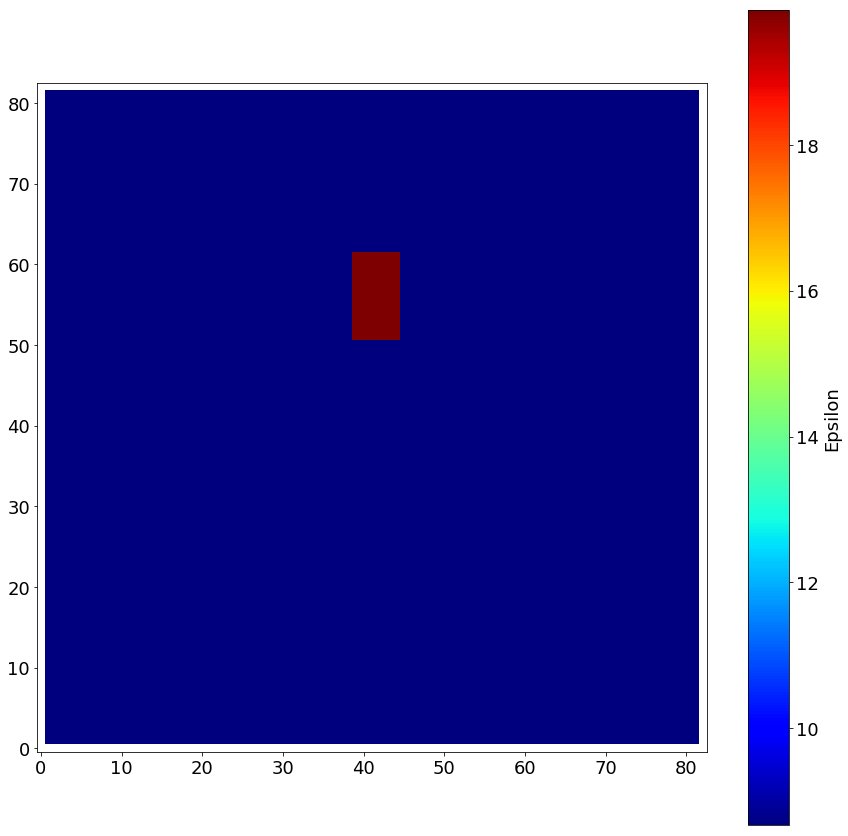

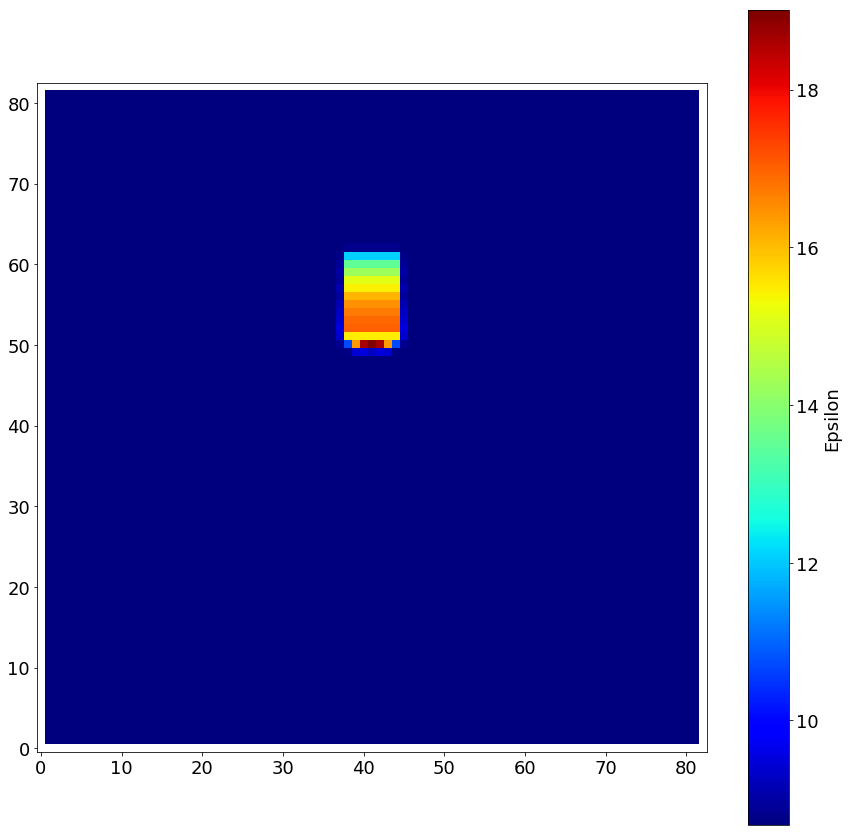

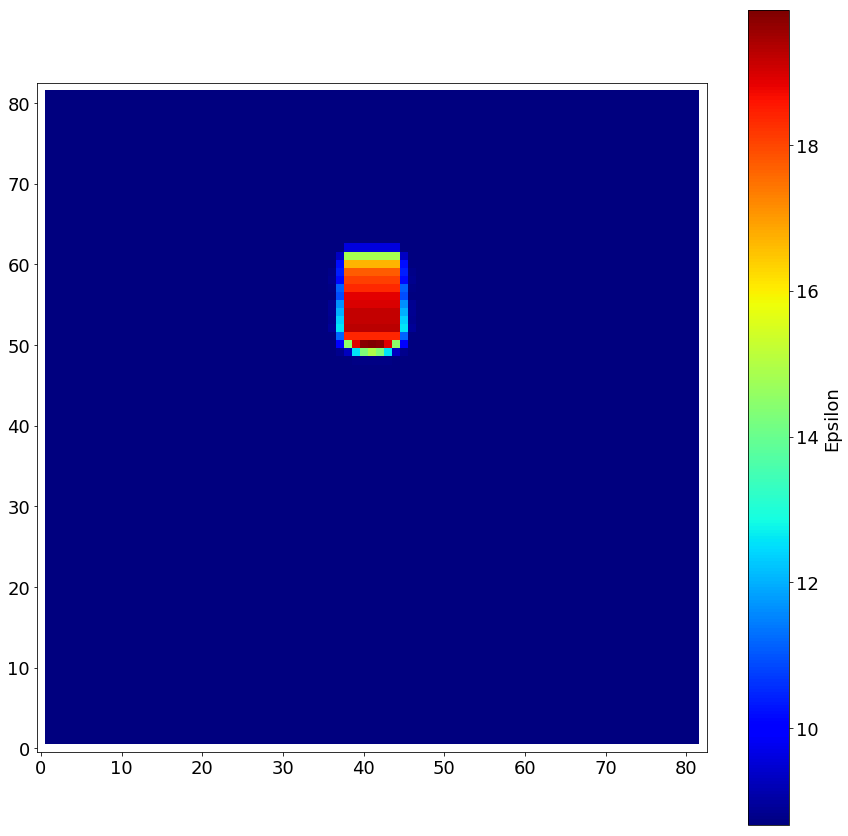

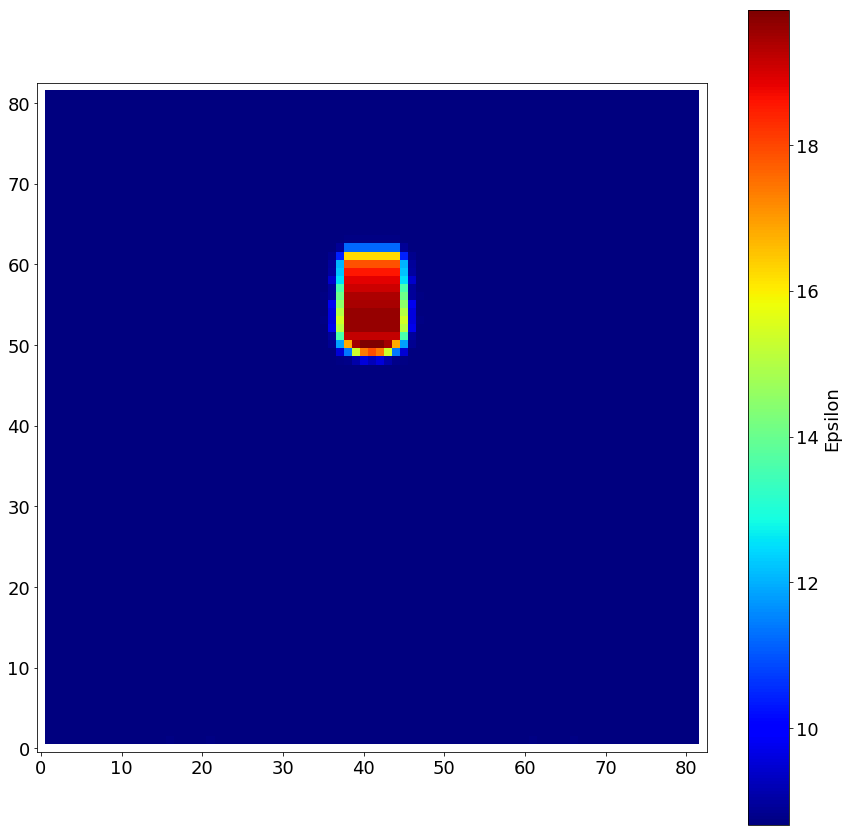

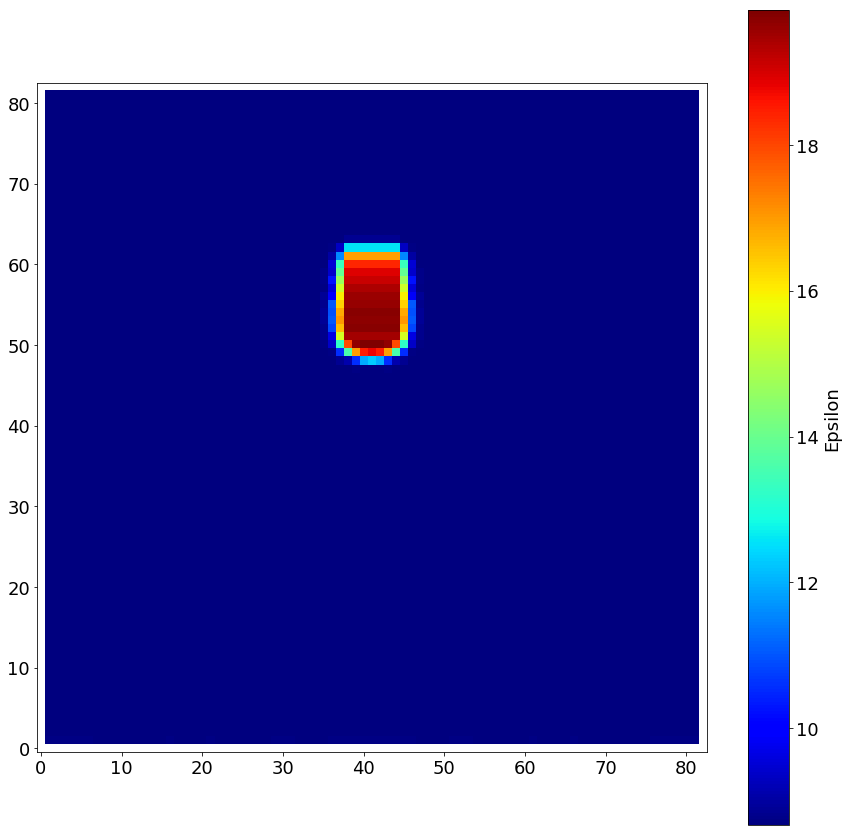

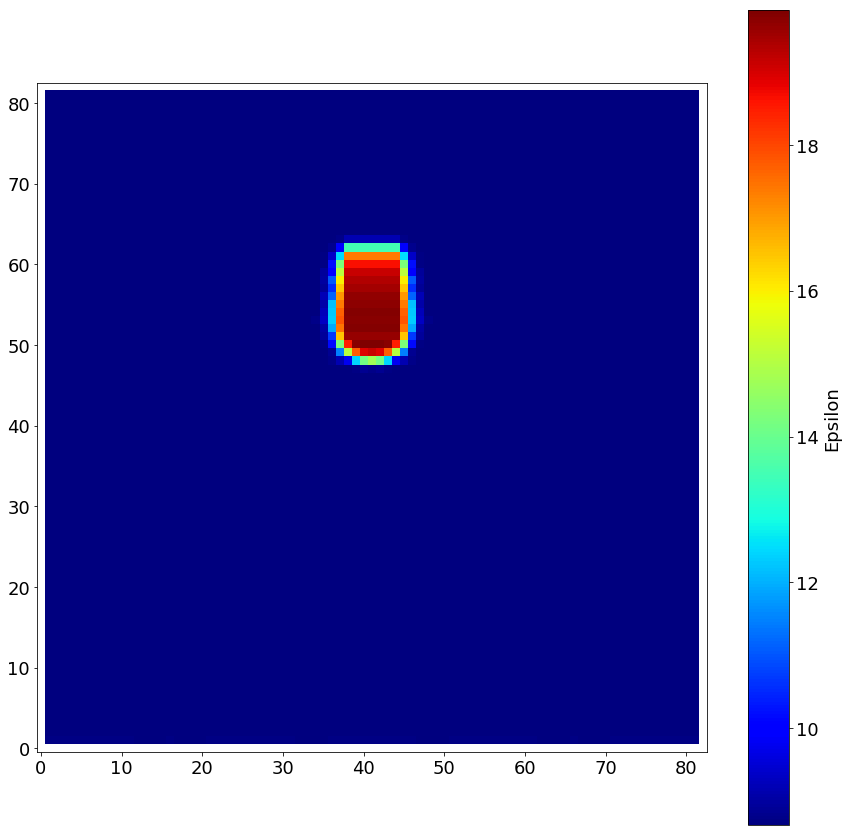

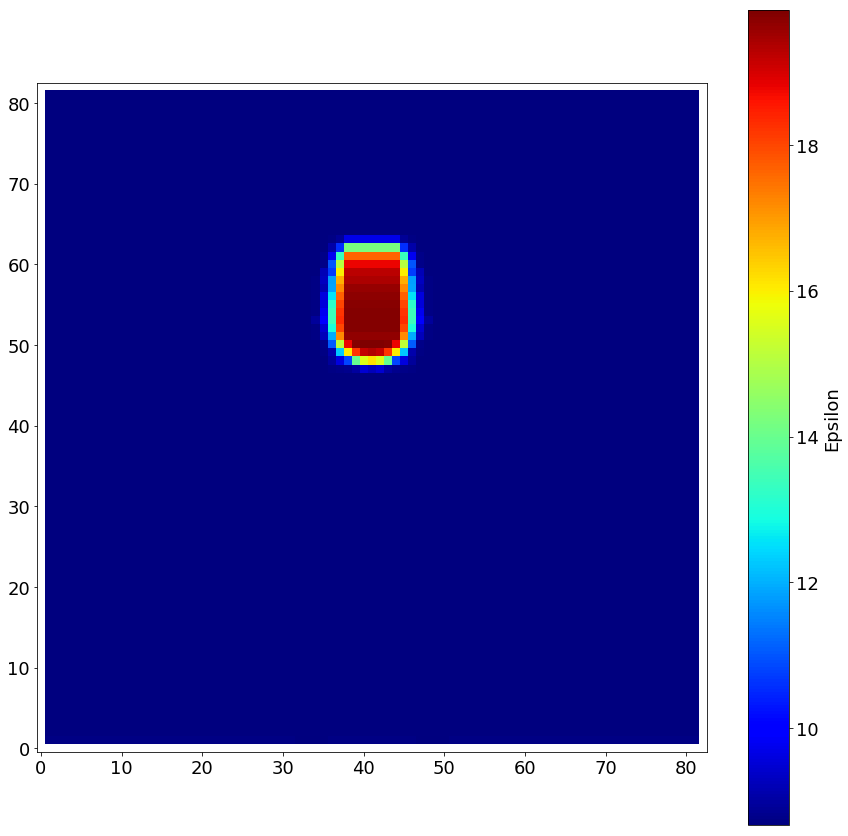

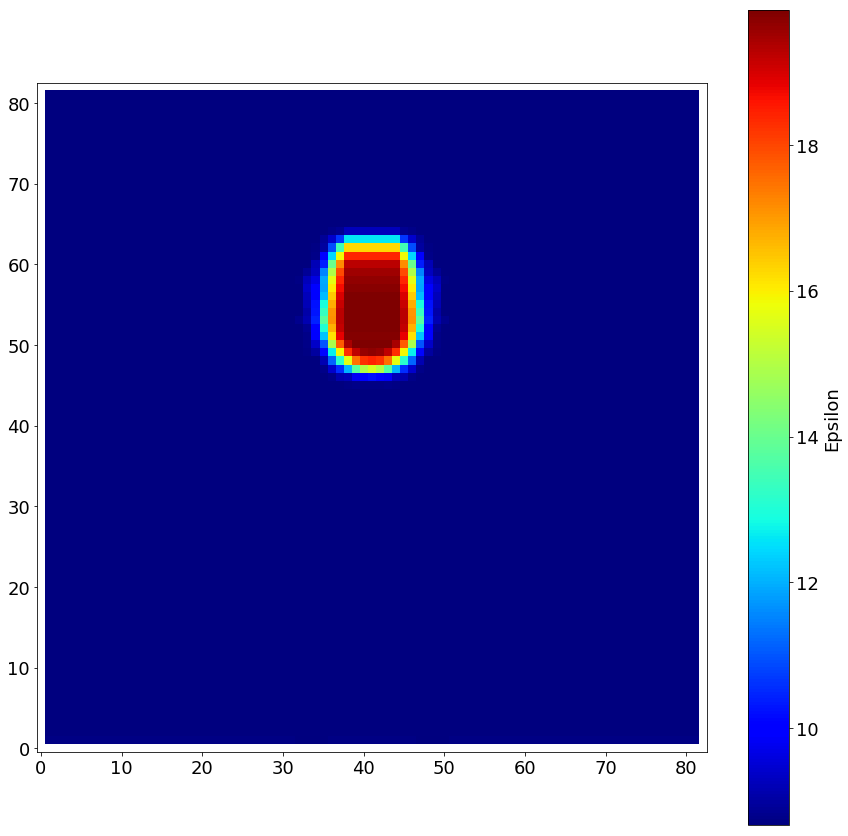

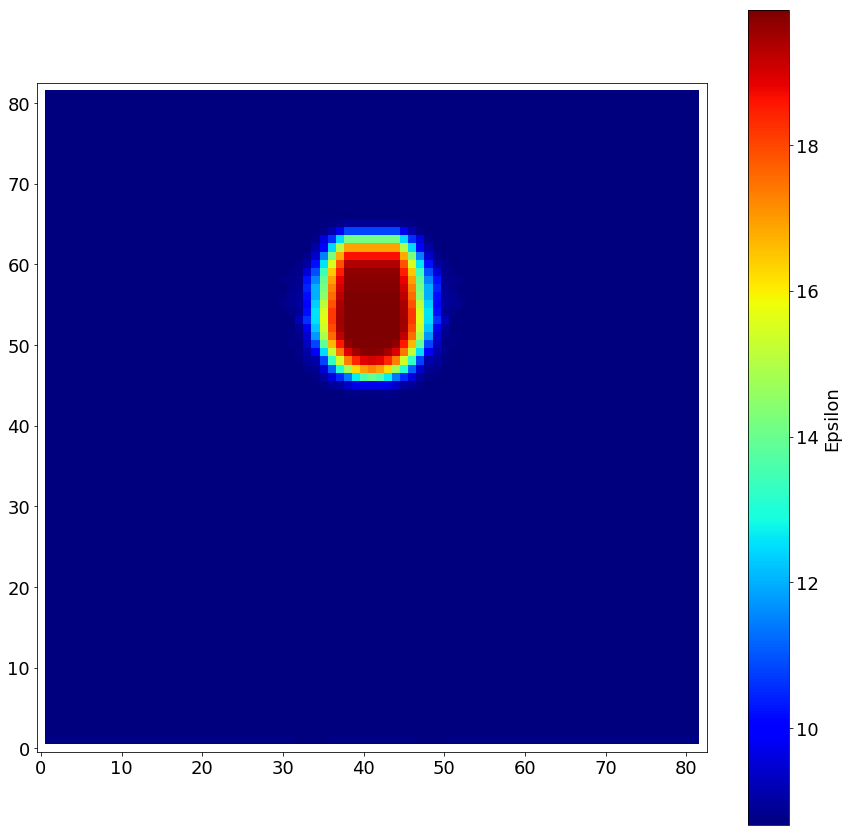

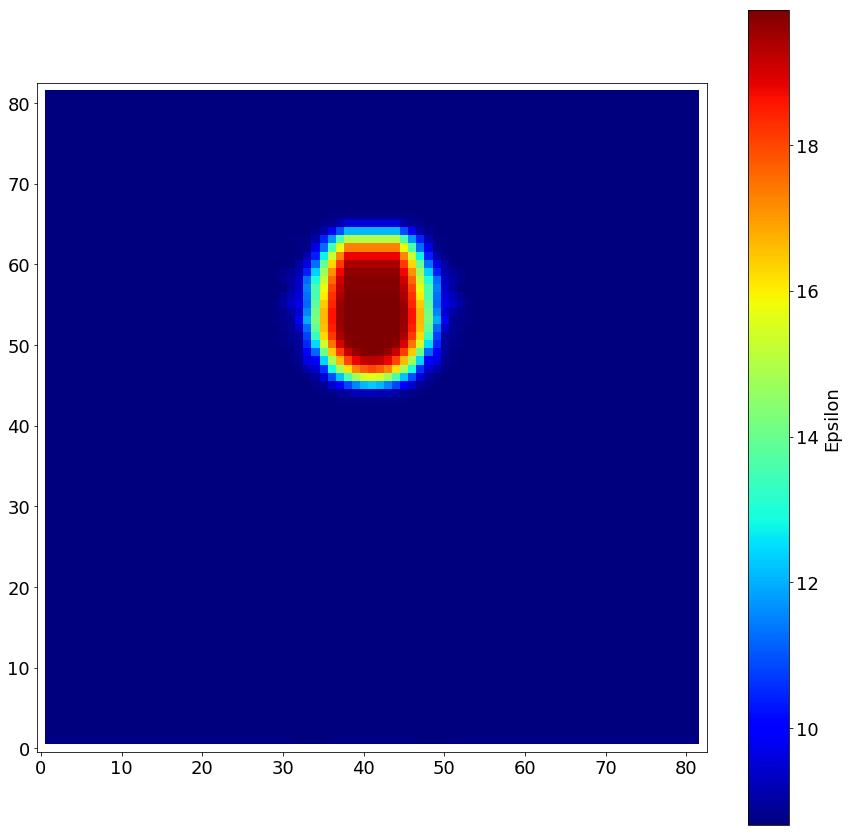

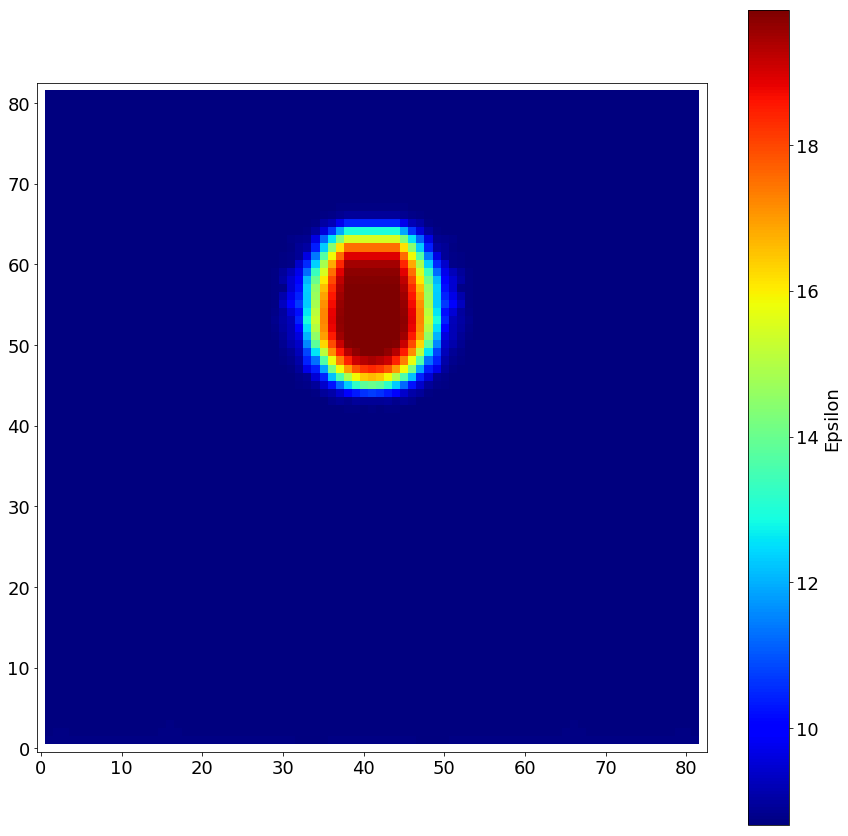

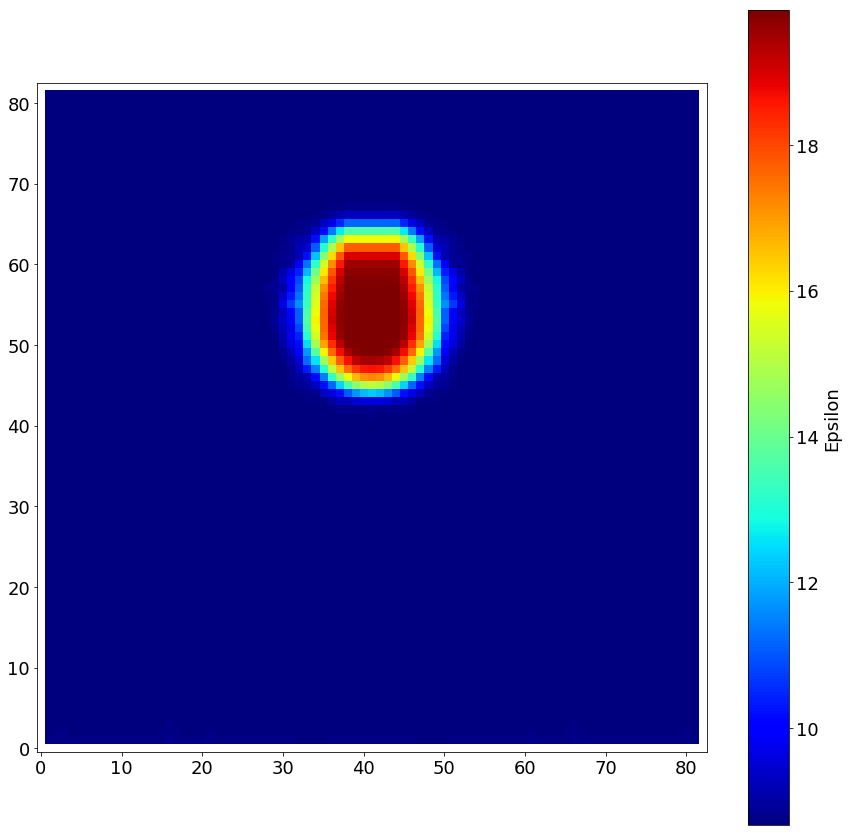

In [26]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colorbar as cb
from matplotlib import cm

#plt.scatter(A[:,0], A[:,1], s=300, c=A[:,2])
#plt.xticks((0,40,80),fontsize=50)
#plt.yticks((0,40,80), fontsize=50)
#xi,yi=np.meshgrid(A.round(3)[:,0], A.round(3)[:,1])
xi=np.arange(-0.01,0.82,0.01)
yi=xi
grid_x, grid_y = np.meshgrid(xi,yi)

for i in range(0,len(tps)):
    Agrid=griddata(A_tab[i][:,0:2], A_tab[i][:,2], (grid_x,grid_y))

    fig,ax=plt.subplots(figsize=(15,15))
    cax=ax.imshow(Agrid, origin='lower', interpolation='nearest',cmap=cm.jet)
    cbar=fig.colorbar(cax)
    cbar.set_label('Epsilon',fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()
#fig=ax.imshow(Agrid, origin='lower', cmap='jet')
#cbar=fig.colorbar()

In [ ]:
xi=np.arange(0,0.82,0.01)
yi=xi
grid_x, grid_y = np.meshgrid(xi,yi)

In [ ]:
yi=xi

In [ ]:
grid_x, grid_y = np.meshgrid(xi,yi)

In [ ]:
A_tab

In [ ]:
grid_x.shape

In [ ]:
i=[0,3.9]

In [ ]:
materiaux[i[1]]

In [ ]:
A[o]

In [ ]:
ii=np.unique(A[o][:,1])
blou=A[o]
for i in ii:
    a=np.where(A[o,1]==i)
    b=np.where((A[:,0]==0.44) & (A[:,1]==i))
    for ii in a[1]:
        blou[ii,2]=A[b,2]
        A[o]=blou       

In [ ]:
a=np.where(A[:,1]==i)

In [ ]:
a=np.where(A[o][:,]

In [ ]:
a=np.where(A[o,1]==0.5)

In [ ]:
a=np.where((A[:,0]==0.44) & (A[:,1]==0.5))
print(a)

In [ ]:
type(i)

In [ ]:
a=np.where(A[:,1]==0.41)
print(a)

In [ ]:
A[o].shape

In [ ]:
materiaux